# NTDS Project

Team members: 
* Armand Boschin
* Bojana Ranković
* Quentin Rebjock

As a reminder, this is a reminder of the project proposal:

***Graph:*** Wikipedia hyperlink network

***Problem:*** Does the structure of the graph bears info on the content of the nodes ? We would like to find out if it is possible to detect communities of pages just by looking at the hyperlink connections and match these communities with real-world data such as categories of the pages.

***Steps of the project:***
* Scraping the Wikipedia hyperlink network. Start from one node and get the pages as far as 2 or 3 hops depending on the number of nodes we get.
* Try to apply spectral clustering in order to detect clusters of pages.
* Visualize the clusters to match them with real-world categories (using some of the tools from the last guest lecture).
* Model the network by a random graph/scale-free network/something else in order to try to retrieve some of its characteristics.
* Improve the community detection using for example the Louvain algorithm.


In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings
import networkx as nx
import pickle
import wikipedia
import scipy

from tqdm import tqdm_notebook
from scipy import sparse, linalg
from bs4 import BeautifulSoup

%matplotlib inline
warnings.simplefilter(action='ignore', category=UserWarning)

# 1) Data Acquisition

We want to acquire a sub-network of the Wikipedia hyperlink network. In such a graph, each node is a Wikipedia page and there is a link between node a and node b is there is a link to page b on page a. This is a directed network but we will make it undirected later on.

The process of the acquisition is the following : 
* Start from an arbitrary root node (prefer and ambiguous page in order to get as many different communities as possible).
* Explore the page to get the intra-wiki links and get first nodes.
* For each first node, explore the intra-wiki links to get the second nodes.
* Eventually look for inner links by exploring the second nodes (no link from a second node to a first node has been added yet).


We use the `Wikipedia` API that allows us to scrap pages and get links and categories for each one. We chose to include in our network only real pages (not the disambiguation ones). Those pages are indeed useful during the scraping because they allow us to get a larger sample of the real graph. Disambiguation pages act like bridges between pages that have nothing to do together.

For each node we need to get URL, title, most important category and links to other pages.

In [2]:
def explore_page(page_title, network, to_explore, inner=False, all_nodes=None):
    if page_title not in network.keys():
        # then this page has not been explored yet
        try:
            page = wikipedia.page(page_title)  # get the page
            title = page.original_title
            if title not in network.keys():  # check if the original title has already been explored
                if not inner:
                    network[title] = {'links' : page.links, 'categories' : page.categories, 'url' : page.url}
                    for node in page.links:
                        to_explore.append(node)
                else:
                    links = list(set(page.links).intersection(set(all_nodes)))
                    network[title] = {'links' : links, 'categories' : page.categories, 'url' : page.url}
        except wikipedia.DisambiguationError as e:
            if inner:
                # We are only looking for inner links, no need to explore the disambiguation page.
                return
            print('Disambiguation of : {}'.format(page_title))
            links = e.options  # those are the pages listed in the disambiguation page
            for node in links:
                    to_explore.append(node)
        except wikipedia.PageError:
            # page does not exist nothing we can do
            return
        except wikipedia.RedirectError:
            return

We use as `root_node` the disambiguation page [Jaguar](https://en.wikipedia.org/wiki/Jaguar_(disambiguation) as it lists a really wide variety of themes (animals, cars, music, films, weapons...). The aim is to scrap pages from as many different communities as possible.

In [3]:
root_node = 'Jaguar (disambiguation)'

In [4]:
network = {}  # This dict stores for each page the list of its neighbors.
first_nodes = []

In [5]:
explore_page(root_node, network, first_nodes)

Disambiguation of : Jaguar (disambiguation)


In [6]:
second_nodes = []
for node in first_nodes:
    explore_page(node, network, second_nodes)

Disambiguation of : Banzai!
Disambiguation of : Jaguares (disambiguation)


Look for connections between second nodes and the rest of the nodes.

In [7]:
all_nodes = list(network.keys()) + second_nodes
for link in tqdm_notebook(second_nodes):
    explore_page(link, network, [], inner=True, all_nodes=all_nodes)

HBox(children=(IntProgress(value=0, max=8176), HTML(value='')))

Now we need to go through all the second nodes that were added to the dictionnary `Network` in order to remove from their neighbors the disambiguation pages that can have been added.

In [12]:
all_nodes = list(network.keys())
for title in tqdm_notebook(second_nodes):
    network[title]['links'] = list(set(network[title]['links']).intersection(set(all_nodes)))

HBox(children=(IntProgress(value=0, max=6864), HTML(value='')))

In [37]:
l = list(network.keys())
for i in l:
    if len(network[i]['links']) == 0:
        del network[i]

#### Creating pickle files

As the scraping of the network takes quite some time (especially getting the inner connections), we store the results in pickle files.

In [ ]:
def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

save_obj(network, 'network')

"""
network = load_obj('network')
"""

### Network creation

Let's convert the collected network into a networkx instance which is quite handy to manipulate.

Let's make it undirected as well.

In [38]:
len(network)

6830

In [22]:
list(network.keys())[0]

'Sports car'

In [39]:
neighbors = {}
for i in network.keys():
    neighbors[i] = network[i]['links']

In [40]:
g = nx.Graph(neighbors)

In [41]:
nx.write_gml(g, "base_graph.gml")

# 2) Data Exploration

In this part of the notebook, we provide some indicators of the data in order to understand what we'll be working on.

TODO: properties of the collected network

* Adjacency matrix
* Degrees distribution
* Average degree
* Diameter of the collected network
* (Pruning the collected network if necessary ?)
* Visualization of the network

In [ ]:
print('Total number of nodes : {}'.format(len(network)))

#### Adjacency Matrix

In [42]:
adj = nx.adjacency_matrix(g)

In [43]:
plt.rcParams['figure.figsize'] = (10, 10)

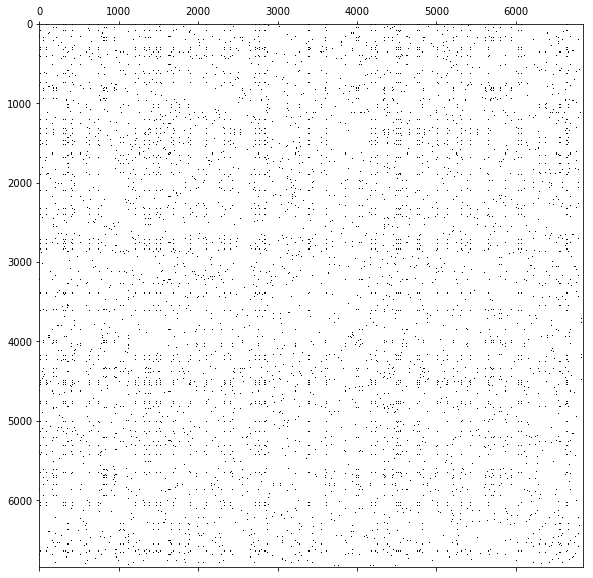

In [44]:
plt.spy(adj.todense())

Check if it's symmetric :

In [45]:
(adj != adj.T)

<6845x6845 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>

#### Degrees distribution

As there are some clear outliers making the visualization difficult, we can truncate the degrees or just use a box plot.

In [46]:
degrees = np.array(adj.sum(axis=1))
degrees_truncated = degrees[degrees < 700]

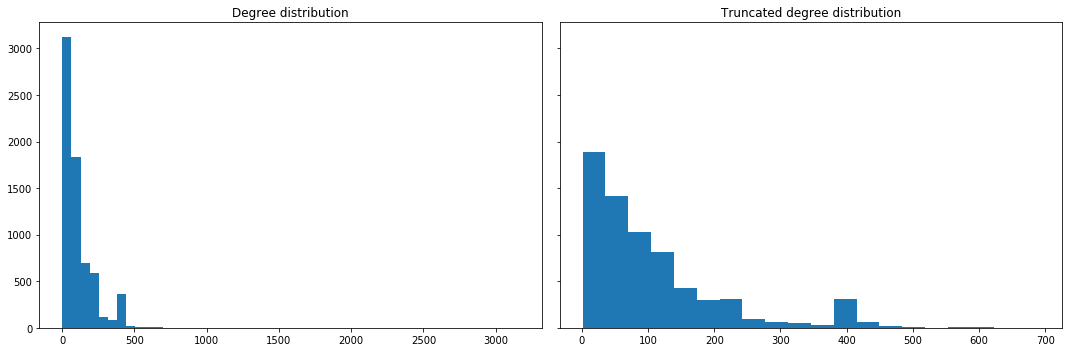

In [47]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

ax[0].set_title('Degree distribution')
#sns.distplot(degrees, bins=50, ax=ax[0, 0])
ax[0].hist(degrees, bins=50)

ax[1].set_title('Truncated degree distribution')
#sns.distplot(degrees_truncated, bins=20, ax=ax[0, 1])
ax[1].hist(degrees_truncated, bins=20)

plt.tight_layout()
plt.show()

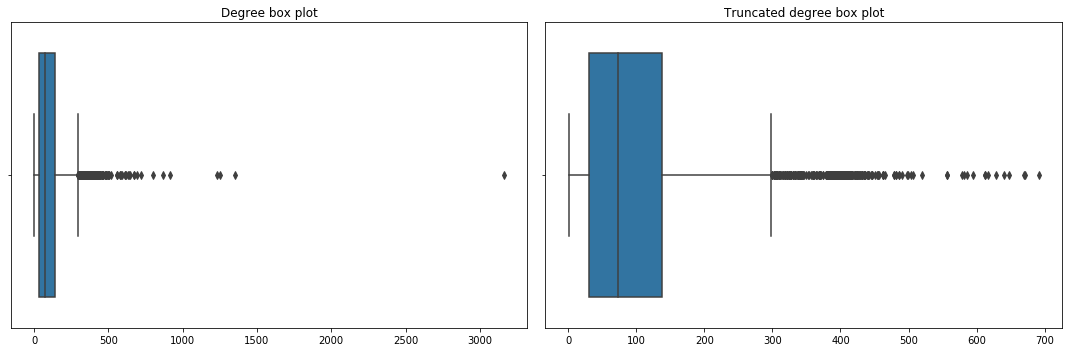

In [48]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

ax[0].set_title('Degree box plot')
sns.boxplot(degrees, ax=ax[0])

ax[1].set_title('Truncated degree box plot')
sns.boxplot(degrees_truncated, ax=ax[1])

plt.tight_layout()
plt.show()

#### Average degree

In [49]:
avg_degree = np.mean(degrees)
print('The average degree of the network is {}.'.format(np.round(avg_degree, 2)))

The average degree of the network is 107.58.


#### Diameter

In [50]:
#Didn't end after 1 hour of computation...
diameter = nx.diameter(g)
print('The diameter of the network is {}.'.format(diameter))

KeyboardInterrupt: 

#### Visualization

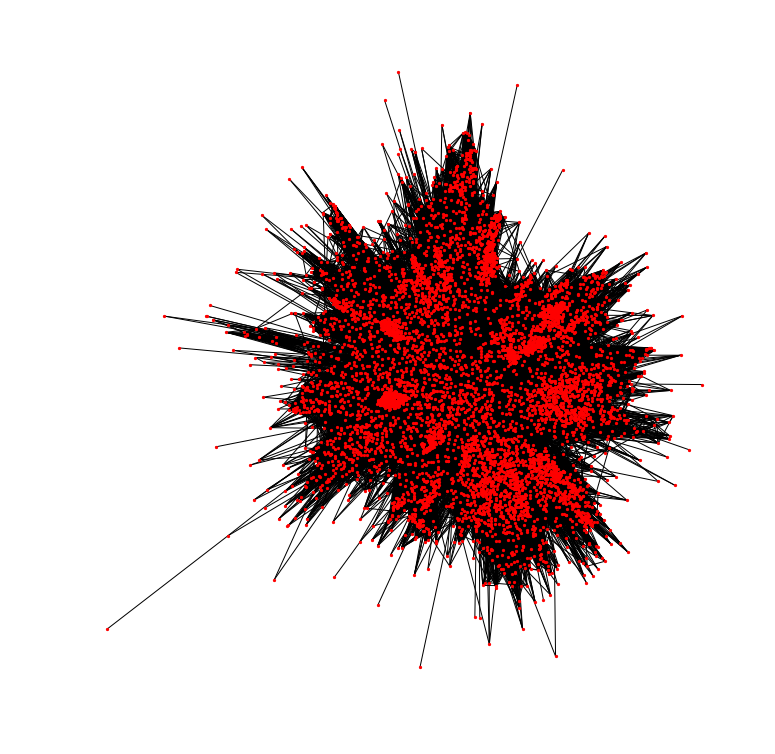

In [51]:
nx.draw(g, node_size=5)

# 3) Data Exploitation

We will try to use the collected data to answer our problem which is: 
 **Can we isolate communities of pages just by looking at the hyperlink graph ? **
 
The steps are the following :
 * Spectral clustering
 * Visualization of the communities
 * Modelization of the network
 * Improvement of the clustering ?
 
 
 * Visualize a random walk on the graph ? Signal processing on the graph. If we take a uniform signal (uniform distribution) and let the signal evolve randomly, what do we get ? Get we get hubs ?

## Spectral Clustering

In [61]:
nx.is_connected(g)

True

The graph is connected.

#### Using the Adjacency matrix

We define the graph laplacian using the formula $L = D- A$ where $D$ is the diagonal matrix containing the degrees and $A$ is the adjacency matrix.

In [52]:
laplacian = np.diag(degrees) - adj

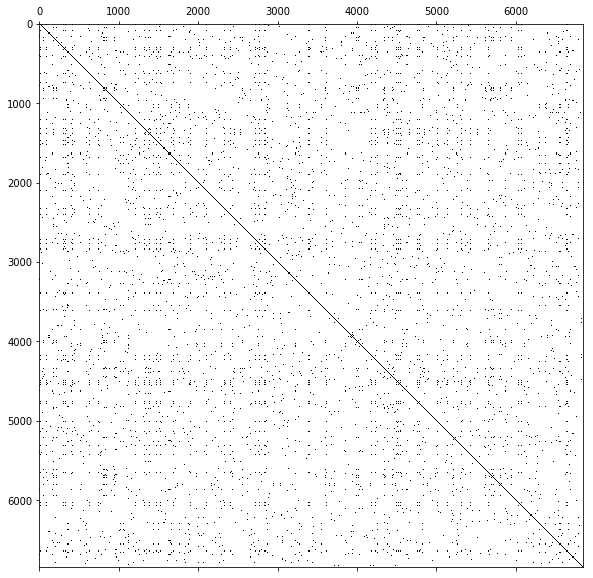

In [53]:
plt.spy(laplacian)

In order to do spectral clustering using this Laplacian, we need to compute the $k$ first eigenvalues and corresponding eigenvectors. We get a matrix $U$ of $\mathbb{R}^{n \times k}$ where $n$ is the number of nodes in the graph. Applying a k-means algorithm in order to cluster the $n$ vectors of $\mathbb{R}^k$ corresponding to the lines of $U$ gives us a clustering of the $n$ nodes.

In [54]:
eigenvalues, eigenvectors = linalg.eigh(laplacian, eigvals=(0, 39))

In [57]:
centroids, labels = scipy.cluster.vq.kmeans2(eigenvectors, 40)

In order to get a first idea of how this algorithm did, let's look at the number of nodes in each cluster.

In [ ]:
cc = [0 for i in range(40)]
for i in labels:
    cc[i] += 1
', '.join([str(i) for i in cc])

We can see that with almost all the clusters containing 1 or 2 nodes, this first algorithm did not perform really well.

#### Defining a distance matrix

If we look closer at our adjacency matrix, two nodes are either at a distance 1 or at distance infinity (not related). Let's try to compute the distances in the graph and create weighted edges based on this distance.

First we'll define the weight of an edge between nodes $i$ and $j$ to be the natural distance in the original graph if it's smaller than a threshold (e.g. 4).

In [ ]:
p = dict(nx.shortest_path_length(g))
len(p)

In [ ]:
p['Sports car']

In [ ]:
w = np.zeros(shape=(len(network), len(network)))
nodes = list(network.keys())

for i in range(len(network)):
    weight[i][j] = p[nodes[i]][nodes[j]]
    weight[j][i] = p[nodes[j]][nodes[i]]

NB: The above computation cannot be vectorized as we are getting the distances from a dictionnary.

In [ ]:
laplacian = np.diag(1/np.sqrt(degrees)).dot((np.diag(degrees) - w).dot(np.diag(1/np.sqrt(degrees))))

plt.spy(laplacian)

In [ ]:
eigenvalues, eigenvectors = linalg.eigh(laplacian, eigvals=(0, 39))
centroids, labels = scipy.cluster.vq.kmeans2(eigenvectors, 40)

In [ ]:
cc = [0 for i in range(40)]
for i in labels:
    cc[i] += 1
', '.join([str(i) for i in cc])

## Modelisation of the network

In [ ]:
def plot_degree_distr(graph):
    d = list(dict(graph.degree()).values())
    plt.hist(list(d), bins = 16);
    plt.ylabel('Number of vertices')
    plt.xlabel('Degree')
    plt.title('Degree distribution')
    plt.show()

In [ ]:
nNodes = len(g.nodes())
nEdges = g.size()

print('The network has {0} nodes and {1} edges.'.format(nNodes, nEdges))

We would like to create a model with approximatively the same number of nodes and edges, and with the same degree distribution.

#### Erdős–Rényi graph

In [ ]:
p = 2*nEdges/nNodes/(nNodes - 1)
p

In [ ]:
er = nx.erdos_renyi_graph(nNodes, p)

plot_degree_distr(er)

It clearly doesn't match the distribution of our network.

#### Barabási-Albert

In [ ]:
ba=nx.barabasi_albert_graph(nNodes, 68)

print('This Barabási-Albert network has {} edges.'.format(ba.size()))

In [ ]:
plot_degree_distr(ba)

In [ ]:
ba_degrees = list(dict(ba.degree()).values())


plt.hist(degrees_truncated, 20, alpha=0.5, label='Collected network')
plt.hist(ba_degrees, 20, alpha=0.5, label='Barabási-Albert network')
plt.legend(loc='upper right')
plt.show()

#### Giant components

# 4) Louvain community detection

In [ ]:
import wikipedia
import wikipediaapi
import community
import json

from tqdm import tqdm

In [ ]:
G = nx.read_gml('data/base_graph.gml')
partition = community.best_partition(G)

In [ ]:
community2color = {
    0: sns.xkcd_rgb["peach"],
    1: sns.xkcd_rgb["powder blue"],
    2: sns.xkcd_rgb["light pink"],
    3: sns.xkcd_rgb["chocolate"],
    4: sns.xkcd_rgb["orange"],
    5: sns.xkcd_rgb["magenta"],
    6: sns.xkcd_rgb["purple"],
    7: sns.xkcd_rgb["blue"],
    8: sns.xkcd_rgb["deep blue"],
    9: sns.xkcd_rgb["sky blue"],
    10: sns.xkcd_rgb["olive"],
    11: sns.xkcd_rgb["seafoam green"],
    12: sns.xkcd_rgb["tan"],
    13: sns.xkcd_rgb["mauve"],
    14: sns.xkcd_rgb["hot pink"],
    15: sns.xkcd_rgb["pale green"],
    16: sns.xkcd_rgb["indigo"],
    17: sns.xkcd_rgb["lavender"],
    18: sns.xkcd_rgb["eggplant"],
    19: sns.xkcd_rgb["brick"],
}

In [ ]:
position = nx.spring_layout(G)

for comunity in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == comunity]
    nx.draw_networkx_nodes(G, position, list_nodes, node_size = 20,
                                node_color = community2color[comunity])


nx.draw_networkx_edges(G, position, alpha=0.5)
plt.show()


In [ ]:
mod = community.modularity(partition,G)
print(mod)

In [ ]:
soup = BeautifulSoup(requests.get('https://en.wikipedia.org/wiki/Jaguar_(Marvel_Comics)').text)

In [ ]:
category_links = soup.find("div", {"class": "mw-normal-catlinks"})

In [ ]:
for ultag in category_links.find_all('ul'):
        for litag in ultag.find_all('li')[0]:
            print(litag.text)

In [ ]:
def find_node_category(page_link):
    """
    :param page_link: url of the current page
    :return: first and most important category the page belongs to
    """
    
    soup = BeautifulSoup(requests.get('https://en.wikipedia.org'+page_link).text)
    category_links = soup.find("div", {"class": "mw-normal-catlinks"})
    
    
    # each page contains multiple categories listed in li tags, we are interested in the first one
    
    for ultag in category_links.find_all('ul'):
        for litag in ultag.find_all('li')[0]:
            return litag.text
    
find_node_category('/wiki/Jaguar_(disambiguation)')

In [ ]:
find_node_category('/wiki/Jaguar_(Marvel_Comics)')

In [ ]:
node2category={}
for node in tqdm(G.nodes):
    try:
        node2category[node]=find_node_category(node)
    except:
        node2category[node]='Unknown'

In [ ]:
def save_categories(node2category):
    with open('data/node_categories.json', 'w') as fp:
        json.dump(node2category, fp)
save_categories(node2category)

In [ ]:
def load_categories(category_file):
    with open(category_file) as json_data:
        return json.load(json_data)
node2category = load_categories('data/node_categories.json')

In [ ]:
nx.set_node_attributes(G, partition, 'community')
nx.set_node_attributes(G, node2category, 'category')


In [ ]:
G.node['/wiki/Jaguar_(novel)']

In [ ]:
nx.write_gml(G, "data/full_graph.gml")


In [ ]:
G = nx.read_gml("data/full_graph.gml")

In [ ]:
from IPython.display import Image, display


In [ ]:
Communities by Louvain.

In [ ]:
display(Image(filename='data/louvain.png', embed=True))

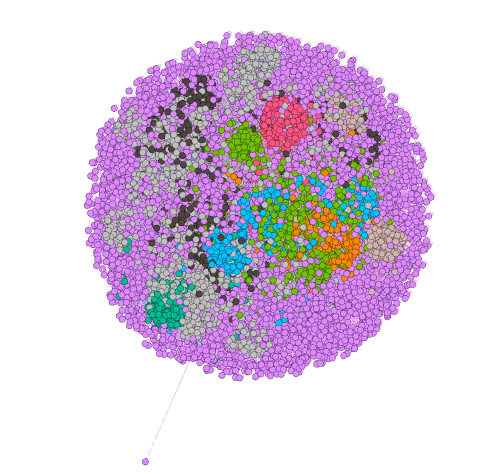

Communities by category


In [ ]:
display(Image(filename='data/communities by category.png', embed=True))

In [ ]:
def find_inner_links(page_name):
    """
    :param page_name: name of the current page
    :return: list of the intra wiki urls contained in the current page
    """
    # Get the HTML code of the page.
    links = []
    page = wiki_wiki.page(page_name)
    # Look for all the <li> tags contained in the page.
    page_titles = list(page.links.keys())
    for title in page_titles:
        if wiki_wiki.page(title).exists():
            links.append(wiki_wiki.page(title).fullurl[24:])
            
    return links

# 5) Conclusion